# Linear Regression Diagonostics

_UNDER CONSTRUCTION_


- Linear regression diagnostics, HAC robust standard errors
- Residual analysis: outliers, leverage, influential points
- Multicollinearity, variance inflation factor


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns 
import patsy
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from finds.readers import Alfred
from finds.plots import plot_fitted, plot_leverage, plot_scale, plot_qq
from finds.misc import Show
from secret import credentials, paths
show = Show(ndigits=4, latex=None)
VERBOSE = 0
# matplotlib qt

In [2]:
imgdir = paths['images'] / 'ts'
alf = Alfred(api_key=credentials['fred']['api_key'],
             savefile=paths['scratch'] / 'alfred.pkl')

In [3]:
# difference of logs of CPI and PPI monthly series from FRED
series_id, freq, start = 'CPIAUCSL', 'M', 0   #19740101
exog_id = 'WPSFD4131'
#exog_id = 'INDPRO'

data = pd.concat([alf(s, start=start) for s in [series_id, exog_id]], axis=1)
data.index = pd.DatetimeIndex(data.index.astype(str))
data = np.log(data).diff().dropna()  # model changes in logs of the series

## Linear regression


In [4]:
## Run Linear Regression (with one lag)
dmf = (f'{series_id} ~ {series_id}.shift(1) ')
model = smf.ols(formula=dmf, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     454.7
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           2.93e-75
Time:                        10:00:03   Log-Likelihood:                 2720.3
No. Observations:                 593   AIC:                            -5437.
Df Residuals:                     591   BIC:                            -5428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0011      0.00

In [5]:
## Run Linear Regression (with 2 lags)
dmf = (f'{series_id} ~ {series_id}.shift(1) + {series_id}.shift(2)')
model = smf.ols(formula=dmf, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     223.2
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           6.98e-73
Time:                        10:00:03   Log-Likelihood:                 2715.9
No. Observations:                 592   AIC:                            -5426.
Df Residuals:                     589   BIC:                            -5413.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0011      0.00

In [6]:
## Run Linear Regression (with exog and lag)
dmf = (f'{series_id} ~ {series_id}.shift(1) + {exog_id}.shift(1)')
model = smf.ols(formula=dmf, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     253.1
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           4.20e-80
Time:                        10:00:03   Log-Likelihood:                 2734.8
No. Observations:                 593   AIC:                            -5464.
Df Residuals:                     590   BIC:                            -5451.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

In [7]:
# Heteroskedasity and HAC robust errors
robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
print(robust.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     173.6
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           4.98e-60
Time:                        10:00:03   Log-Likelihood:                 2734.8
No. Observations:                 593   AIC:                            -5464.
Df Residuals:                     590   BIC:                            -5451.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

In [8]:
Y, X = patsy.dmatrices(dmf + ' - 1', data=data)  # exclude intercept term  
show(Series({X.design_info.column_names[i]: variance_inflation_factor(X, i)
             for i in range(X.shape[1])}, name='VIF').to_frame(),
     caption="Variance Inflation Factors")

,VIF
Variance Inflation Factors,
CPIAUCSL.shift(1),2.0559
WPSFD4131.shift(1),2.0559


## Residual plots

date,2005-09-30,2008-10-31,2008-11-30
Residual Outliers,,,
outliers,0.0092,-0.0109,-0.0156


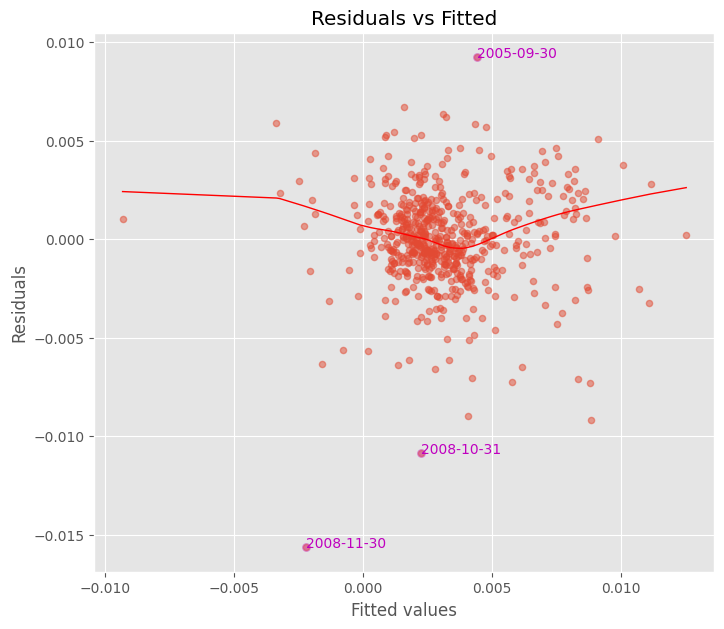

In [9]:
## Plot residuals and identify outliers
fig, ax = plt.subplots(clear=True, figsize=(8,7))
z = plot_fitted(fitted=model.fittedvalues,
                resid=model.resid,
                ax=ax)
plt.savefig(imgdir / 'outliers.jpg')
show(z.to_frame().T, caption="Residual Outliers")
#plt.show()

/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


,residuals,standardized
date,,
2008-11-30,-0.015636,-6.505301
2008-10-31,-0.010866,-4.521038
2022-07-31,-0.009155,-3.809182
2006-09-30,-0.008979,-3.735893
2005-10-31,-0.007286,-3.031274
2008-08-31,-0.007255,-3.018455
1980-07-31,-0.007105,-2.955960
2013-03-31,-0.007025,-2.922866
2005-09-30,0.009246,3.846821


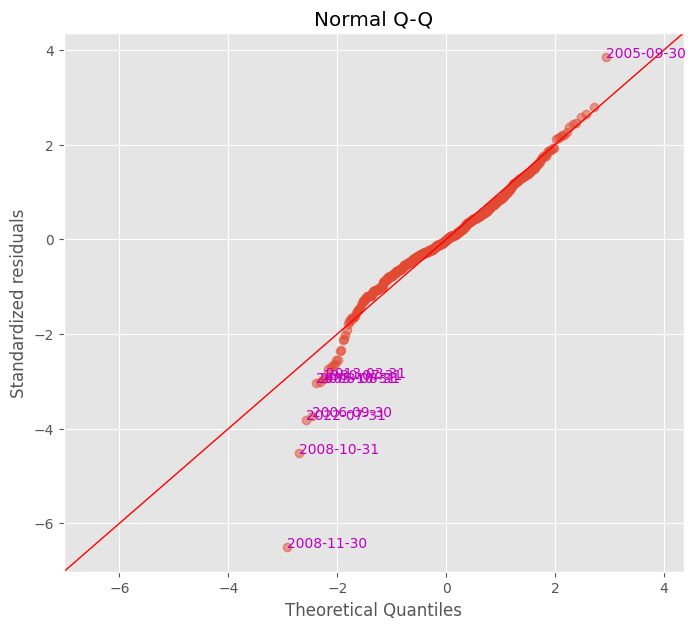

In [10]:
## QQ Plot of residuals and identify outliers
fig, ax = plt.subplots(clear=True, figsize=(8,7))
z = plot_qq(model.resid, ax=ax)
plt.savefig(imgdir / 'qq.jpg')
#plt.show()
z

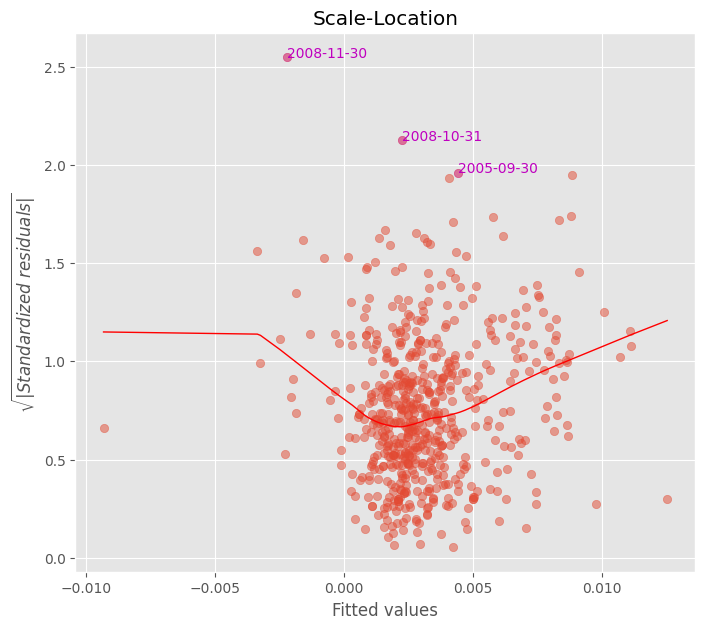

In [11]:
## Plot scale of residuals with outliers
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_scale(model.fittedvalues, model.resid, ax=ax)
plt.savefig(imgdir / 'scale.jpg')

,influential,cook's D,leverage
date,,,


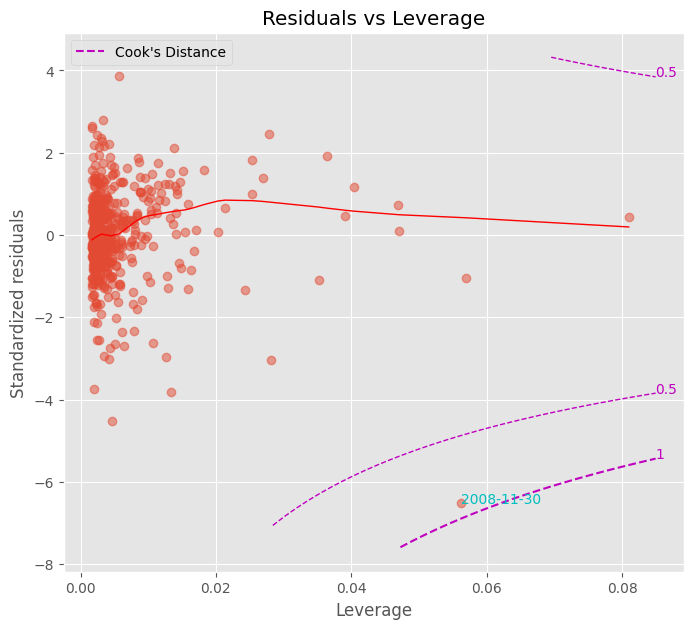

In [12]:
## Plot leverage and identify influential points                 
fig, ax = plt.subplots(clear=True, figsize=(8,7))
z = plot_leverage(model.resid, model.get_influence().hat_matrix_diag,
                  model.get_influence().cooks_distance[0],
                  ddof=len(model.params), ax=ax)
plt.savefig(imgdir / 'leverage.jpg')
z